# Montevideo

Instance took from the set of bycicle network design problems faced by Inco.

In [1]:
from functools import partial
import os

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import networkx as nx

import bcnetwork as bc

## Utils

In [2]:
data_path = '../data/montevideo_v2'

## Draw solutions

Draw solutions computed by the CPLEX solver elsewhere.


In [3]:
instances = []

for entry in os.scandir(data_path):
    if 'solution' in entry.path or not entry.path.endswith('pkl'):
        continue
    
    dirname, basename = os.path.dirname(entry.path), os.path.basename(entry.path)
    solution_path = os.path.join(dirname,'solution_' + basename)
    if not os.path.exists(solution_path):
        continue

    model = bc.model.Model.load(entry.path)
    solution = bc.solution.Solution.load(solution_path)
        
    instances.append((model, solution))

In [4]:
draw_config = dict(
    figsize=(8, 7),
)

split_draw_config = dict()

Sample Model out of 6 models
Nodes: 136
Edges: 636
Multigraph: False
Directed: True
OD count: 734
Breakpoint count: 10
Budget: 648440.474819427


[None]

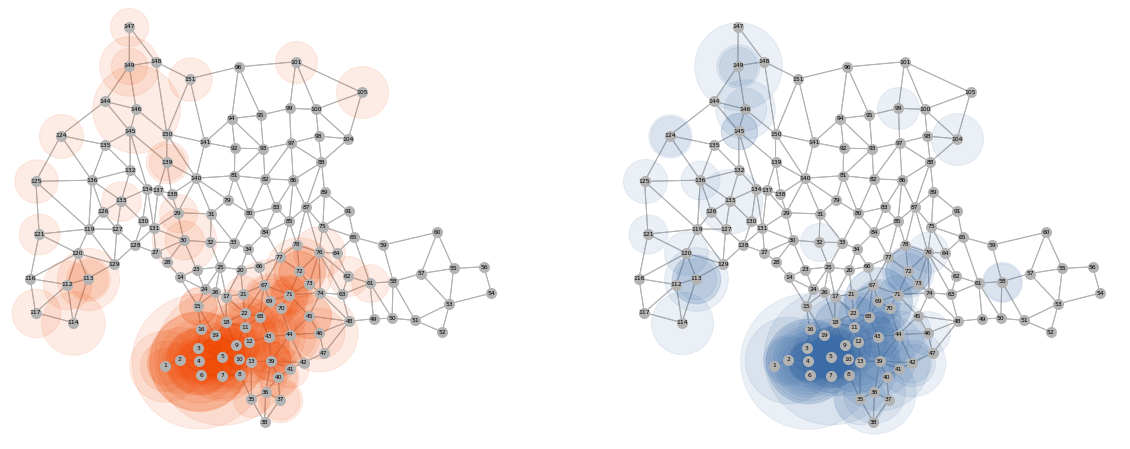

In [5]:
sample_model = instances[0][0]
sample_graph = sample_model.graph

print(f'Sample Model out of', len(instances), 'models')
print(f'Nodes: {sample_graph.number_of_nodes()}')
print(f'Edges: {sample_graph.number_of_edges()}')
print(f'Multigraph: {sample_graph.is_multigraph()}')
print(f'Directed: {sample_graph.is_directed()}')
print(f'OD count: {len(sample_model.odpairs)}')
print(f'Breakpoint count: {len(sample_model.breakpoints)}')
print(f'Budget: {sample_model.budget}')

fig, axs = plt.subplots(nrows=1, ncols=2)
bc.draw.draw(sample_model, odpairs=False, ax=axs[0], **split_draw_config)
bc.draw.draw_demand_weight(axs[0], sample_model, destination_color=None, show_top=100)

bc.draw.draw(sample_model, odpairs=False, ax=axs[1], **split_draw_config)
bc.draw.draw_demand_weight(axs[1], sample_model, origin_color=None, show_top=100)

fig.set(size_inches=(20, 8))

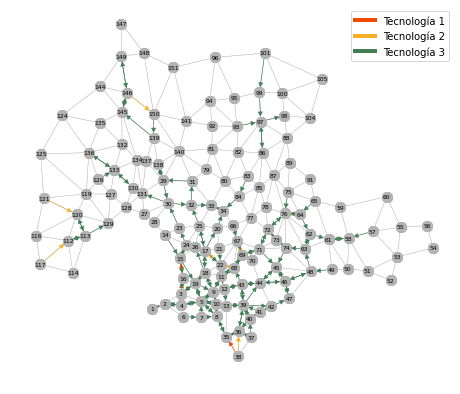

In [6]:
model, solution = instances[0]

bc.draw.draw(
    model,
    solution=solution,
    odpairs=False,
    infrastructures=True,
    width=0.3,
    **draw_config,
)

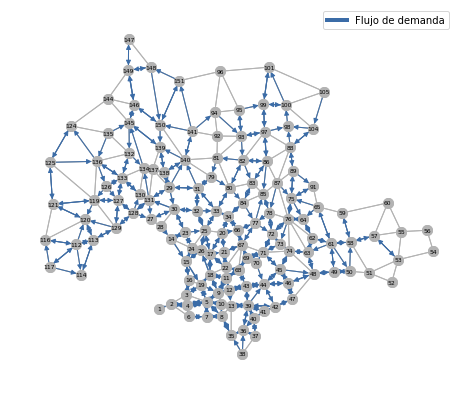

In [7]:
bc.draw.draw(
    model,
    solution=solution,
    odpairs=False,
    infrastructures=False,
    flows=True,
    **draw_config,
)

## Budget usage per instance

In [8]:
bdf = pd.read_csv(os.path.join(data_path, 'abudget_use_summary.csv'))

infra_length_columns = [c for c in bdf.columns if 'length' in c]
bdf['total_length'] = bdf[infra_length_columns].fillna(0.0).apply(np.sum, axis=1)
bdf[['name', 'total_length'] + infra_length_columns]

,name,total_length,infra_1_length_percentage,infra_2_length_percentage,infra_3_length_percentage
0,montevideo_d5000.0_linear_0.4_budget_factor,13.077486,0.394968,5.570413,7.112106
1,montevideo_d5000.0_inv_logit_0.4_budget_factor,10.345872,NaN,0.694257,9.651615
2,montevideo_d5000.0_linear,26.096709,0.657123,11.212564,14.227022
3,montevideo_d5000.0_inv_logit,20.864053,0.337636,1.221774,19.304642
4,montevideo_d5000.0_linear_1.6_budget_factor,44.968258,NaN,9.950273,35.017986
5,montevideo_d5000.0_inv_logit_1.6_budget_factor,41.196177,0.216784,2.075388,38.904006


## Desviacion sobre el camino más corto en distancia

Comparación entre el camino más corto en costo de usuario y el camino más corto en distancia.

In [9]:
def get_shortest_path_cmp(model, solution):
    data = []
    
    graph = model.apply_solution_to_graph(solution)
    
    for (origin, destination, *_) in model.odpairs:      
        distance = nx.shortest_path_length(graph, origin, destination, weight='user_cost')
        user_cost_sp = nx.shortest_path(graph, origin, destination, weight='effective_user_cost')
        
        user_cost_distance = sum([
            graph.edges[n1, n2]['user_cost']
            for n1, n2 in zip(user_cost_sp[0:-1], user_cost_sp[1:])
        ])
        
        data.append(dict(
            od=f'{origin}-{destination}',
            distance=distance,
            user_cost_distance=user_cost_distance,
            ratio=user_cost_distance / distance,
        ))
    
    return pd.DataFrame(data)

In [10]:
dfs = [get_shortest_path_cmp(*instance) for instance in instances]

In [11]:
df = dfs[0]
df[df.ratio > 1.00].sort_values(by=['ratio'], ascending=False)

,od,distance,user_cost_distance,ratio
668,26-33,2134.625759,3332.304905,1.561072
295,44-39,1343.955919,1926.643364,1.433561
605,69-42,2940.239845,4069.266301,1.383991
728,5-3,1155.856861,1598.423893,1.382891
726,71-44,1751.157085,2393.300574,1.366697
...,...,...,...,...
684,11-42,3765.693936,3804.419287,1.010284
612,69-17,2506.256886,2531.288315,1.009988
427,89-69,5429.611546,5472.862992,1.007966
143,12-36,2922.259915,2933.809299,1.003952
